In [169]:
from IPython.utils import io
import os
import subprocess
import tqdm.notebook

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

In [170]:
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf
from collections import Counter

# Styblinski-Tang関数

In [171]:
def styblinski_tang(x):
    indices = [0, 1, 2, 3, 4]
    x_selected = x[..., indices]
    return 0.5 * torch.sum(x_selected ** 4 - 16 * x_selected ** 2 + 5 * x_selected, dim=-1)

# styblinski_tang関数の最適解
global_optimum = -39.16599 * 5

In [172]:
def generate_initial_points(n_initial, dim, bounds):
    return torch.rand(n_initial, dim) * (bounds[1] - bounds[0]) + bounds[0]


def create_model(train_X, train_Y):
    kernel = ScaleKernel(RBFKernel(ard_num_dims=train_X.shape[-1], noise_constraint=1e-5))
    model = SingleTaskGP(train_X, train_Y, covar_module=kernel)
    return model

# ドロップアウトベイズクラス

In [173]:
class DropoutMixBO:
    def __init__(self, X, dim, active_dim, bounds, n_initial, n_iter, obj_function, dropout_prob=0.1):

        self.dim = dim  # 全体の次元数
        self.active_dim = active_dim  # 活性化する次元数
        self.bounds = bounds  # 各次元の探索範囲
        self.obj_function = obj_function  # 最適化したい目的関数
        self.dropout_prob = dropout_prob  # ドロップアウトの確率
        self.X = X  # 初期点を生成
        self.Y = self.obj_function(self.X)  # 初期点での目的関数の値を計算
        self.best_f = self.Y.min().item()  # 現在の最良の目的関数値
        self.best_x = self.X[self.Y.argmin()]  # 現在の最良の解
        self.eval_history = []  # 評価履歴を初期化
        self.n_initial = n_initial
        self.n_max = n_iter
        

    def optimize(self):
        self.eval_history = [self.best_f] * self.n_initial  # 評価履歴を初期化
        n = self.n_initial
        
        while n < self.n_max:
            # 全次元からランダムにactive_dim個選ぶ
            active_dims = np.random.choice(self.dim, self.active_dim, replace=False)

            train_X = self.X[:, active_dims].float()  # 選んだ次元のデータだけ抽出
            train_Y = self.Y.unsqueeze(-1).float()  # Yの形状を調整
            
            model = create_model(train_X, train_Y)  # GPモデルを作成
            mll = ExactMarginalLogLikelihood(model.likelihood, model)  # 尤度関数を定義
            fit_gpytorch_model(mll)  # モデルを学習

            EI = ExpectedImprovement(model, best_f=self.best_f, maximize=False)  # Expected Improvementを定義
            bounds_active = torch.stack([self.bounds[0][active_dims], self.bounds[1][active_dims]]).float()  # 活性化次元の探索範囲を定義
            
            candidate, _ = optimize_acqf(  # 獲得関数を最適化して次の候補点を見つける
                EI, bounds=bounds_active, q=1, num_restarts=10, raw_samples=100,
            )

            x_new = torch.zeros(self.dim)  # 新しい候補点を初期化
            if np.random.random() < self.dropout_prob:  # ドロップアウトを適用するかどうか決める
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                inactive_dims = np.setdiff1d(range(self.dim), active_dims)  # 非活性化次元を特定
                x_new[inactive_dims] = (torch.rand(len(inactive_dims))  # 非活性化次元にランダムな値を設定
                                        * (self.bounds[1][inactive_dims] - self.bounds[0][inactive_dims])
                                        + self.bounds[0][inactive_dims])
            else:
                x_new[active_dims] = candidate.squeeze()  # 活性化次元に候補点の値を設定
                x_new[np.setdiff1d(range(self.dim), active_dims)] = self.best_x[  # 非活性化次元に最良解の値を設定
                    np.setdiff1d(range(self.dim), active_dims)]

            y_new = self.obj_function(x_new.unsqueeze(0))  # 新しい候補点での目的関数値を計算

            self.X = torch.cat([self.X, x_new.unsqueeze(0)])  # データセットに新しい点を追加
            self.Y = torch.cat([self.Y, y_new])  # 目的関数値のリストに新しい値を追加

            if y_new < self.best_f:  # もし新しい点が今までの最良値より良ければ
                self.best_f = y_new.item()  # 最良値を更新
                self.best_x = x_new  # 最良解を更新

            self.eval_history.append(self.best_f)  # 評価履歴に現在の最良値を追加
            
            n += 1  # イテレーションを進める

        return self.best_x, self.best_f  # 最適化が終わったら最良解と最良値を返す

# ECI_BO_Banditクラス

In [174]:
class ECI_BO_Bandit:
    def __init__(self, X, objective_function, bounds, n_initial, n_max, dim, active_dim, gamma=0.99):
        self.objective_function = objective_function
        self.bounds = bounds
        self.n_initial = n_initial
        self.n_max = n_max
        self.dim = dim
        self.active_dim = active_dim
        self.X = X
        self.Y = None
        self.best_value = None
        self.best_point = None
        self.model = None
        self.gamma = gamma

        # Bandit algorithm parameters
        self.dimension_counts = [1] * self.dim
        self.dimension_rewards = [0.0] * self.dim
        self.squared_reward = [0.0] * self.dim

        self.eval_history = []
        self.arm_selection_history = []

    def update_model(self):
        kernel = ScaleKernel(RBFKernel(ard_num_dims=self.X.shape[-1]), noise_constraint=1e-5)
        self.model = SingleTaskGP(self.X, self.Y, covar_module=kernel)
        mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
        fit_gpytorch_model(mll)

    def normalize_rewards(self, rewards):
        if isinstance(rewards, (int, float)):
            return rewards
        if isinstance(rewards, torch.Tensor):
            rewards = rewards.detach().cpu().numpy()
        min_reward = min(rewards)
        max_reward = max(rewards)
        if min_reward == max_reward:
            return [1.0] * len(rewards)
        return [(r - min_reward) / (max_reward - min_reward) for r in rewards]

    def initialize(self):
        self.Y = self.objective_function(self.X).unsqueeze(-1)
        self.best_value = float(self.Y.min().item())
        self.best_point = self.X[self.Y.argmin()].clone()
        self.update_model()
        self.eval_history = [self.best_value] * self.n_initial

        # Calculate initial ECI values and normalize them
        eci_values = self.calculate_eci()
        normalized_eci = self.normalize_rewards(eci_values)
        self.dimension_rewards = [float(r) for r in normalized_eci]
        self.squared_reward = [float(r ** 2) for r in normalized_eci]

    def select_dimension(self, total_iterations):
        ucb_values = []
        for i in range(self.dim):
            if self.dimension_counts[i] == 0:
                ucb_values.append(float('inf'))
            else:
                average_reward = float(self.dimension_rewards[i]) / float(self.dimension_counts[i])
                variance = max(0, float(self.squared_reward[i]) / float(self.dimension_counts[i]) - average_reward ** 2)
                confidence = math.sqrt(2 * variance * math.log(total_iterations + 1) / self.dimension_counts[i])
                confidence += 3 * math.log(total_iterations + 1) / self.dimension_counts[i]
                ucb = average_reward + confidence
                ucb_values.append(float(ucb))

        sorted_indices = sorted(range(self.dim), key=lambda k: ucb_values[k], reverse=True)
        selected_dims = []
        remaining_dims = sorted_indices.copy()
        
        while len(selected_dims) < self.active_dim:
            if not remaining_dims:
                remaining_dims = sorted_indices.copy()
            selected_dims.append(remaining_dims.pop(0))

        return selected_dims

    def calculate_eci(self):
        eci_values = []
        for i in range(self.dim):
            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            def eci_func(x):
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, i] = x.view(-1)
                full_x = full_x.unsqueeze(1)
                return ei(full_x)

            bound = torch.tensor([[self.bounds[0][i]], [self.bounds[1][i]]], device=self.X.device)
            candidate, value = optimize_acqf(
                eci_func, bound, q=1, num_restarts=10, raw_samples=100,
            )
            eci_values.append(float(value.item()))
        return eci_values

    def optimize(self):
        self.initialize()
        n = self.n_initial
        total_iterations = 1

        while n < self.n_max:
            self.update_model()
            selected_dims = self.select_dimension(total_iterations)
            self.arm_selection_history.append(selected_dims)

            ei = ExpectedImprovement(self.model, best_f=self.best_value, maximize=False)

            def eci_func(x):
                batch_size = x.shape[0]
                full_x = self.best_point.clone().unsqueeze(0).expand(batch_size, -1).clone()
                full_x[:, selected_dims] = x.view(batch_size, -1)
                full_x = full_x.unsqueeze(1)
                return ei(full_x)

            bounds = torch.stack([
                torch.tensor([self.bounds[0][i] for i in selected_dims]),
                torch.tensor([self.bounds[1][i] for i in selected_dims])
            ], dim=0).to(self.X.device)

            candidate, acq_value = optimize_acqf(
                eci_func,
                bounds,
                q=1,
                num_restarts=10,
                raw_samples=100,
            )

            new_x = self.best_point.clone()
            new_x[selected_dims] = candidate.squeeze()
            new_y = self.objective_function(new_x.unsqueeze(0)).unsqueeze(-1)

            self.X = torch.cat([self.X, new_x.unsqueeze(0)])
            self.Y = torch.cat([self.Y, new_y])

            improvement = max(0, self.best_value - float(new_y.item()))
            
            # Convert tensor to float for calculations
            for dim in selected_dims:
                reward = float(improvement)
                self.dimension_rewards[dim] = self.gamma * self.dimension_rewards[dim] + reward
                self.squared_reward[dim] = self.gamma * self.squared_reward[dim] + reward ** 2
                self.dimension_counts[dim] += 1

            if new_y.item() < self.best_value:
                self.best_value = float(new_y.item())
                self.best_point = new_x.clone()

            self.eval_history.append(self.best_value)

            n += 1
            total_iterations += 1
            print(f"Iteration {n}, Best value: {self.best_value}")

        return self.best_point, self.best_value

# 最適化の実行

In [175]:
dim = 25
active_dim = 5
bounds = torch.tensor([[-5.0] * dim, [5.0] * dim])
n_initial = 100
n_iter = 600
n_runs = 10
X = generate_initial_points(n_initial, dim, bounds)

In [176]:
dropout_bo_copy_history = []
eci_bo_bandit_history = []
arm_selection_history = []

In [177]:
try:
  with tqdm.notebook.tqdm(total=100, bar_format=TQDM_BAR_FORMAT) as pbar:
    with io.capture_output() as captured:
      for run in range(n_runs):
          dropout_bo_copy = DropoutMixBO(X, dim, active_dim, bounds, n_initial, n_iter, styblinski_tang, dropout_prob=0.0)
          best_x, best_f = dropout_bo_copy.optimize()
          dropout_bo_copy_history.append(dropout_bo_copy.eval_history)
          pbar.update(50 / n_runs)
      dropout_bo_copy_average_history = np.mean(dropout_bo_copy_history, axis=0)
      for run in range(n_runs):
        eci_bo_bandit = ECI_BO_Bandit(X, styblinski_tang, bounds, n_initial, n_iter, dim, active_dim)
        best_x, best_f = eci_bo_bandit.optimize()
        eci_bo_bandit_history.append(eci_bo_bandit.eval_history)
        arm_selection_history.append(eci_bo_bandit.arm_selection_history)  
        pbar.update(50 / n_runs) 
      eci_bo_bandit_history_average = np.mean(eci_bo_bandit_history, axis=0)  
except subprocess.CalledProcessError:
  print(captured)
  raise

  0%|          | 0/100 [elapsed: 00:00 remaining: ?]

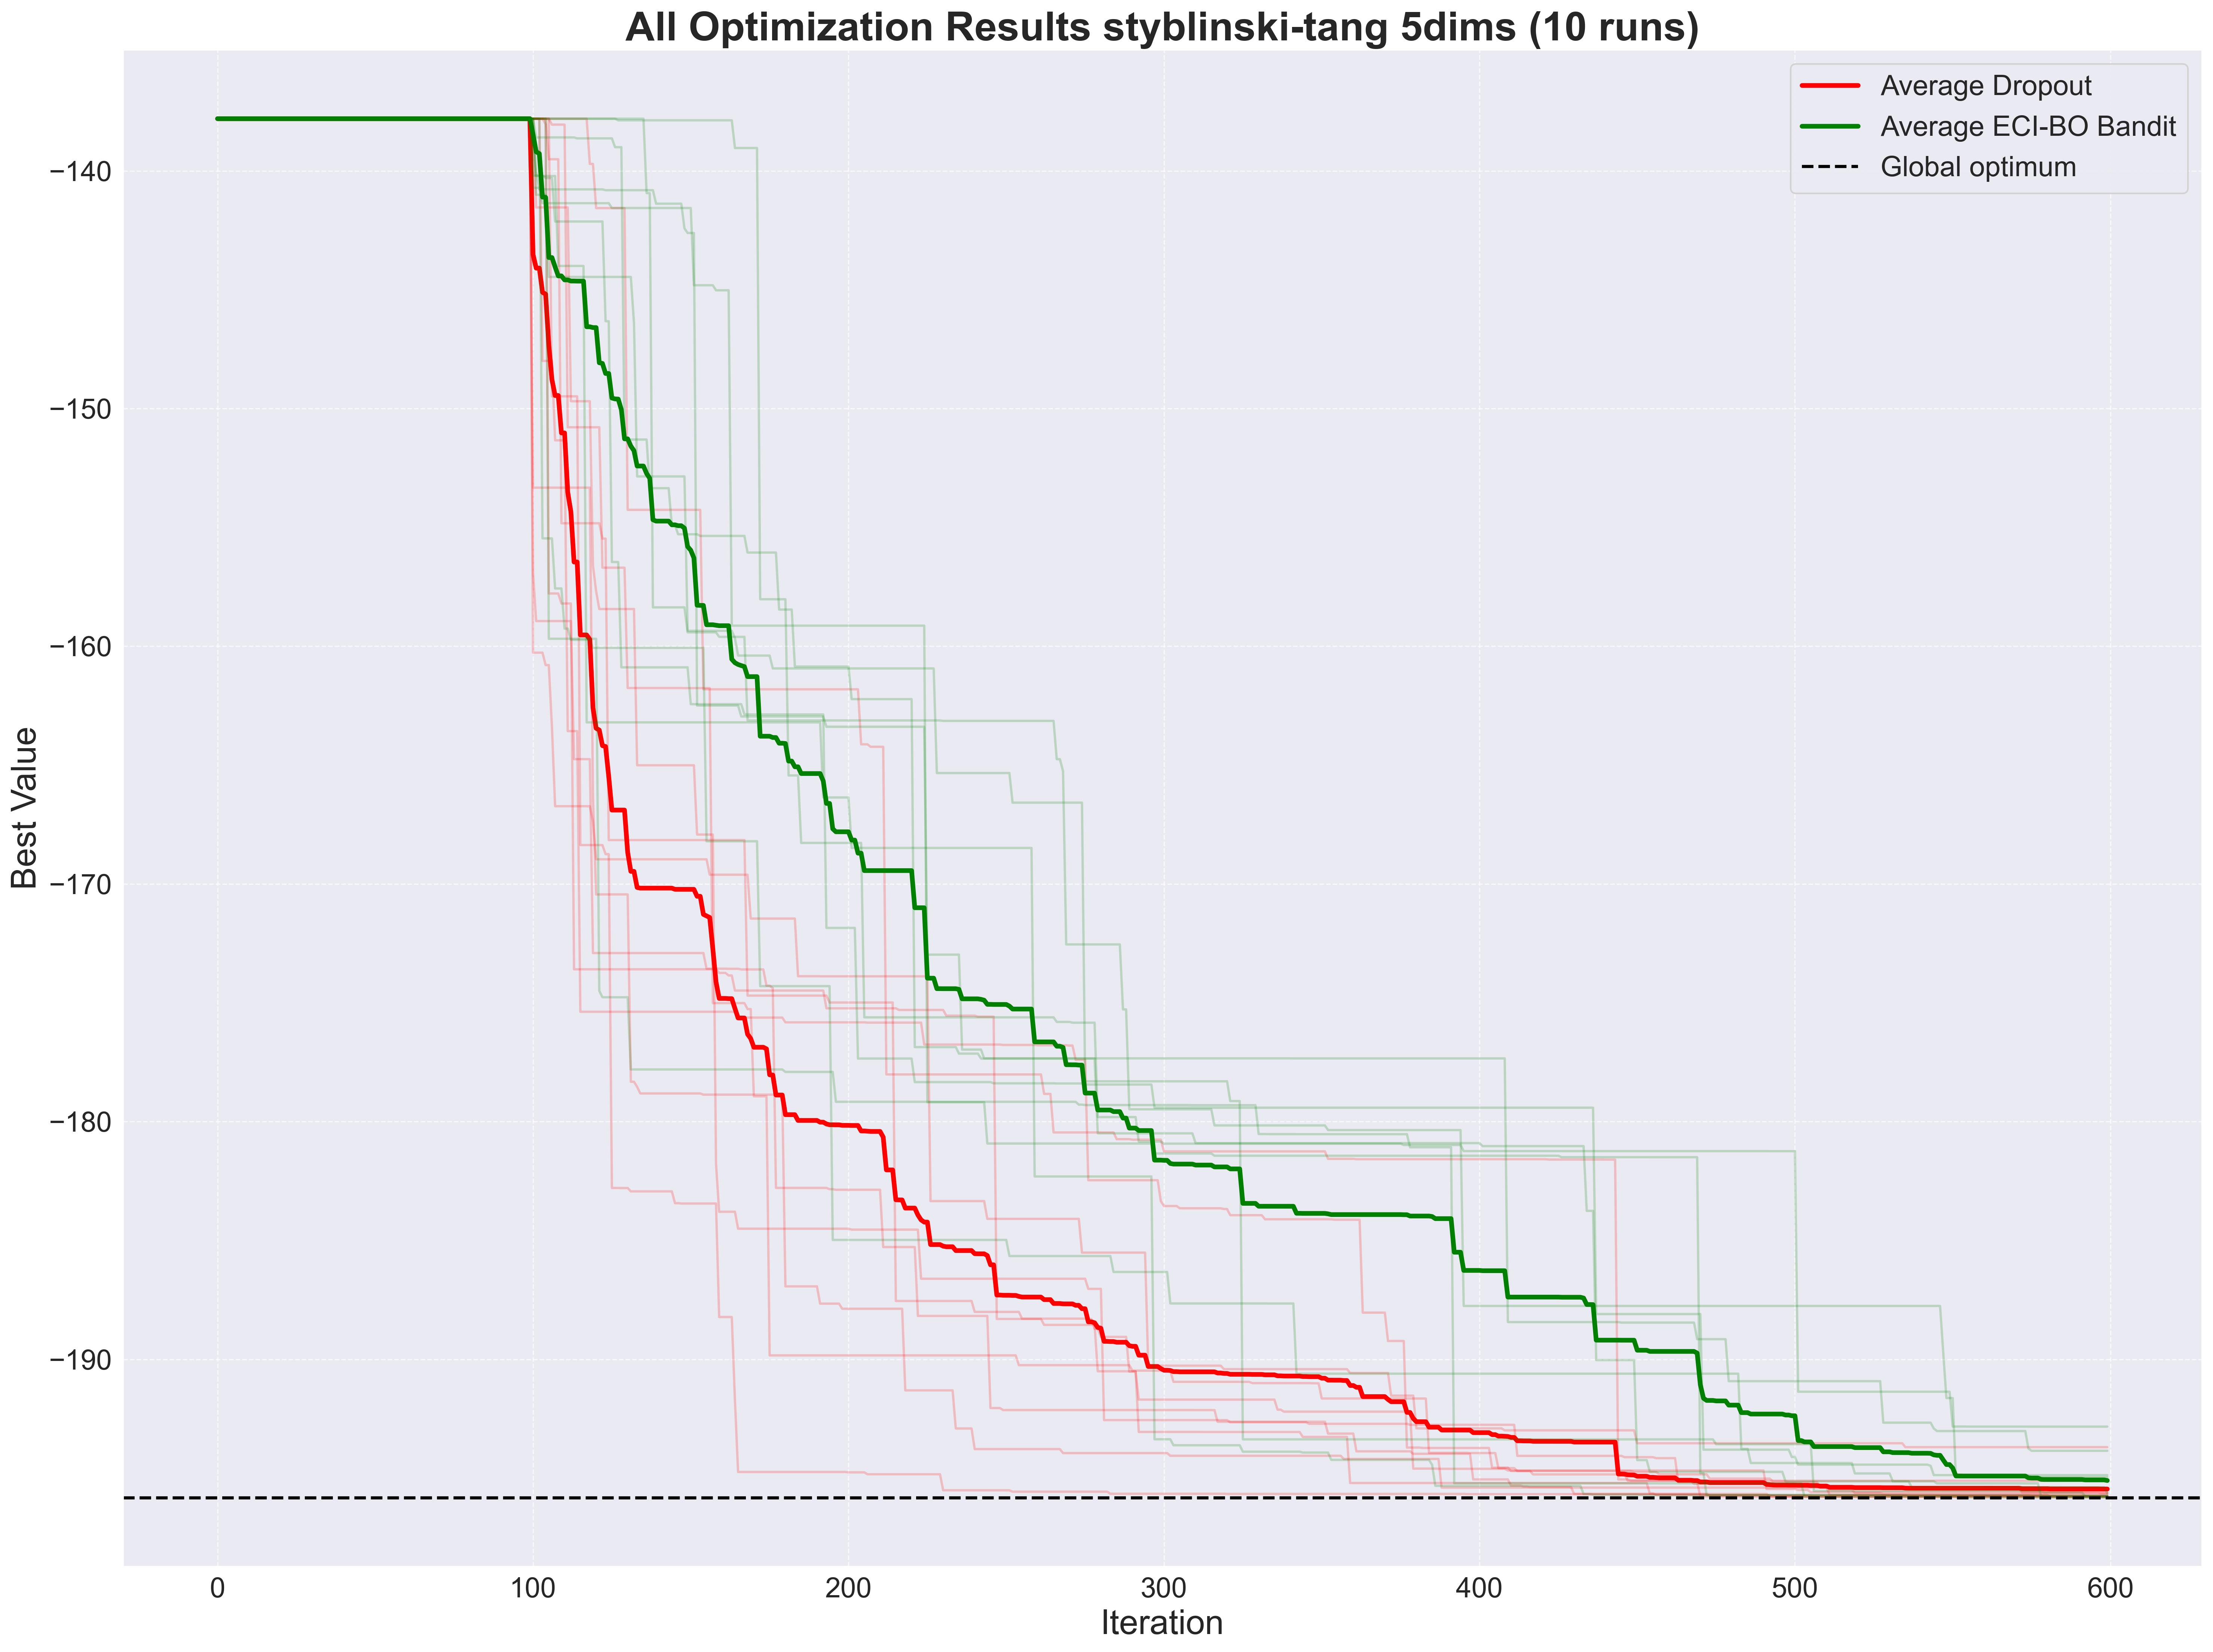

In [178]:
plt.figure(figsize=(20, 15), dpi=300)  # Increased figure size for better visibility

plt.rcParams.update({'font.size': 16})  # Increase the default font size

plt.plot(dropout_bo_copy_average_history, label="Average Dropout", color='red', linewidth=3)
for history in dropout_bo_copy_history:
    plt.plot(history, color='red', alpha=0.2)
plt.plot(eci_bo_bandit_history_average, label="Average ECI-BO Bandit", color='green', linewidth=3)
for history in eci_bo_bandit_history:
    plt.plot(history, color='green', alpha=0.2)
plt.axhline(global_optimum, color="black", linestyle="--", label="Global optimum", linewidth=2)

plt.xlabel("Iteration", fontsize=22)
plt.ylabel("Best Value", fontsize=22)
plt.title(f"All Optimization Results styblinski-tang 5dims ({n_runs} runs)", fontsize=26, fontweight='bold')
plt.legend(fontsize=18, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()  # Adjust the plot to ensure all labels are visible

# Save the plot as a high-resolution PNG file
plt.savefig('optimization_results_high_res_large_font.png', dpi=300, bbox_inches='tight')

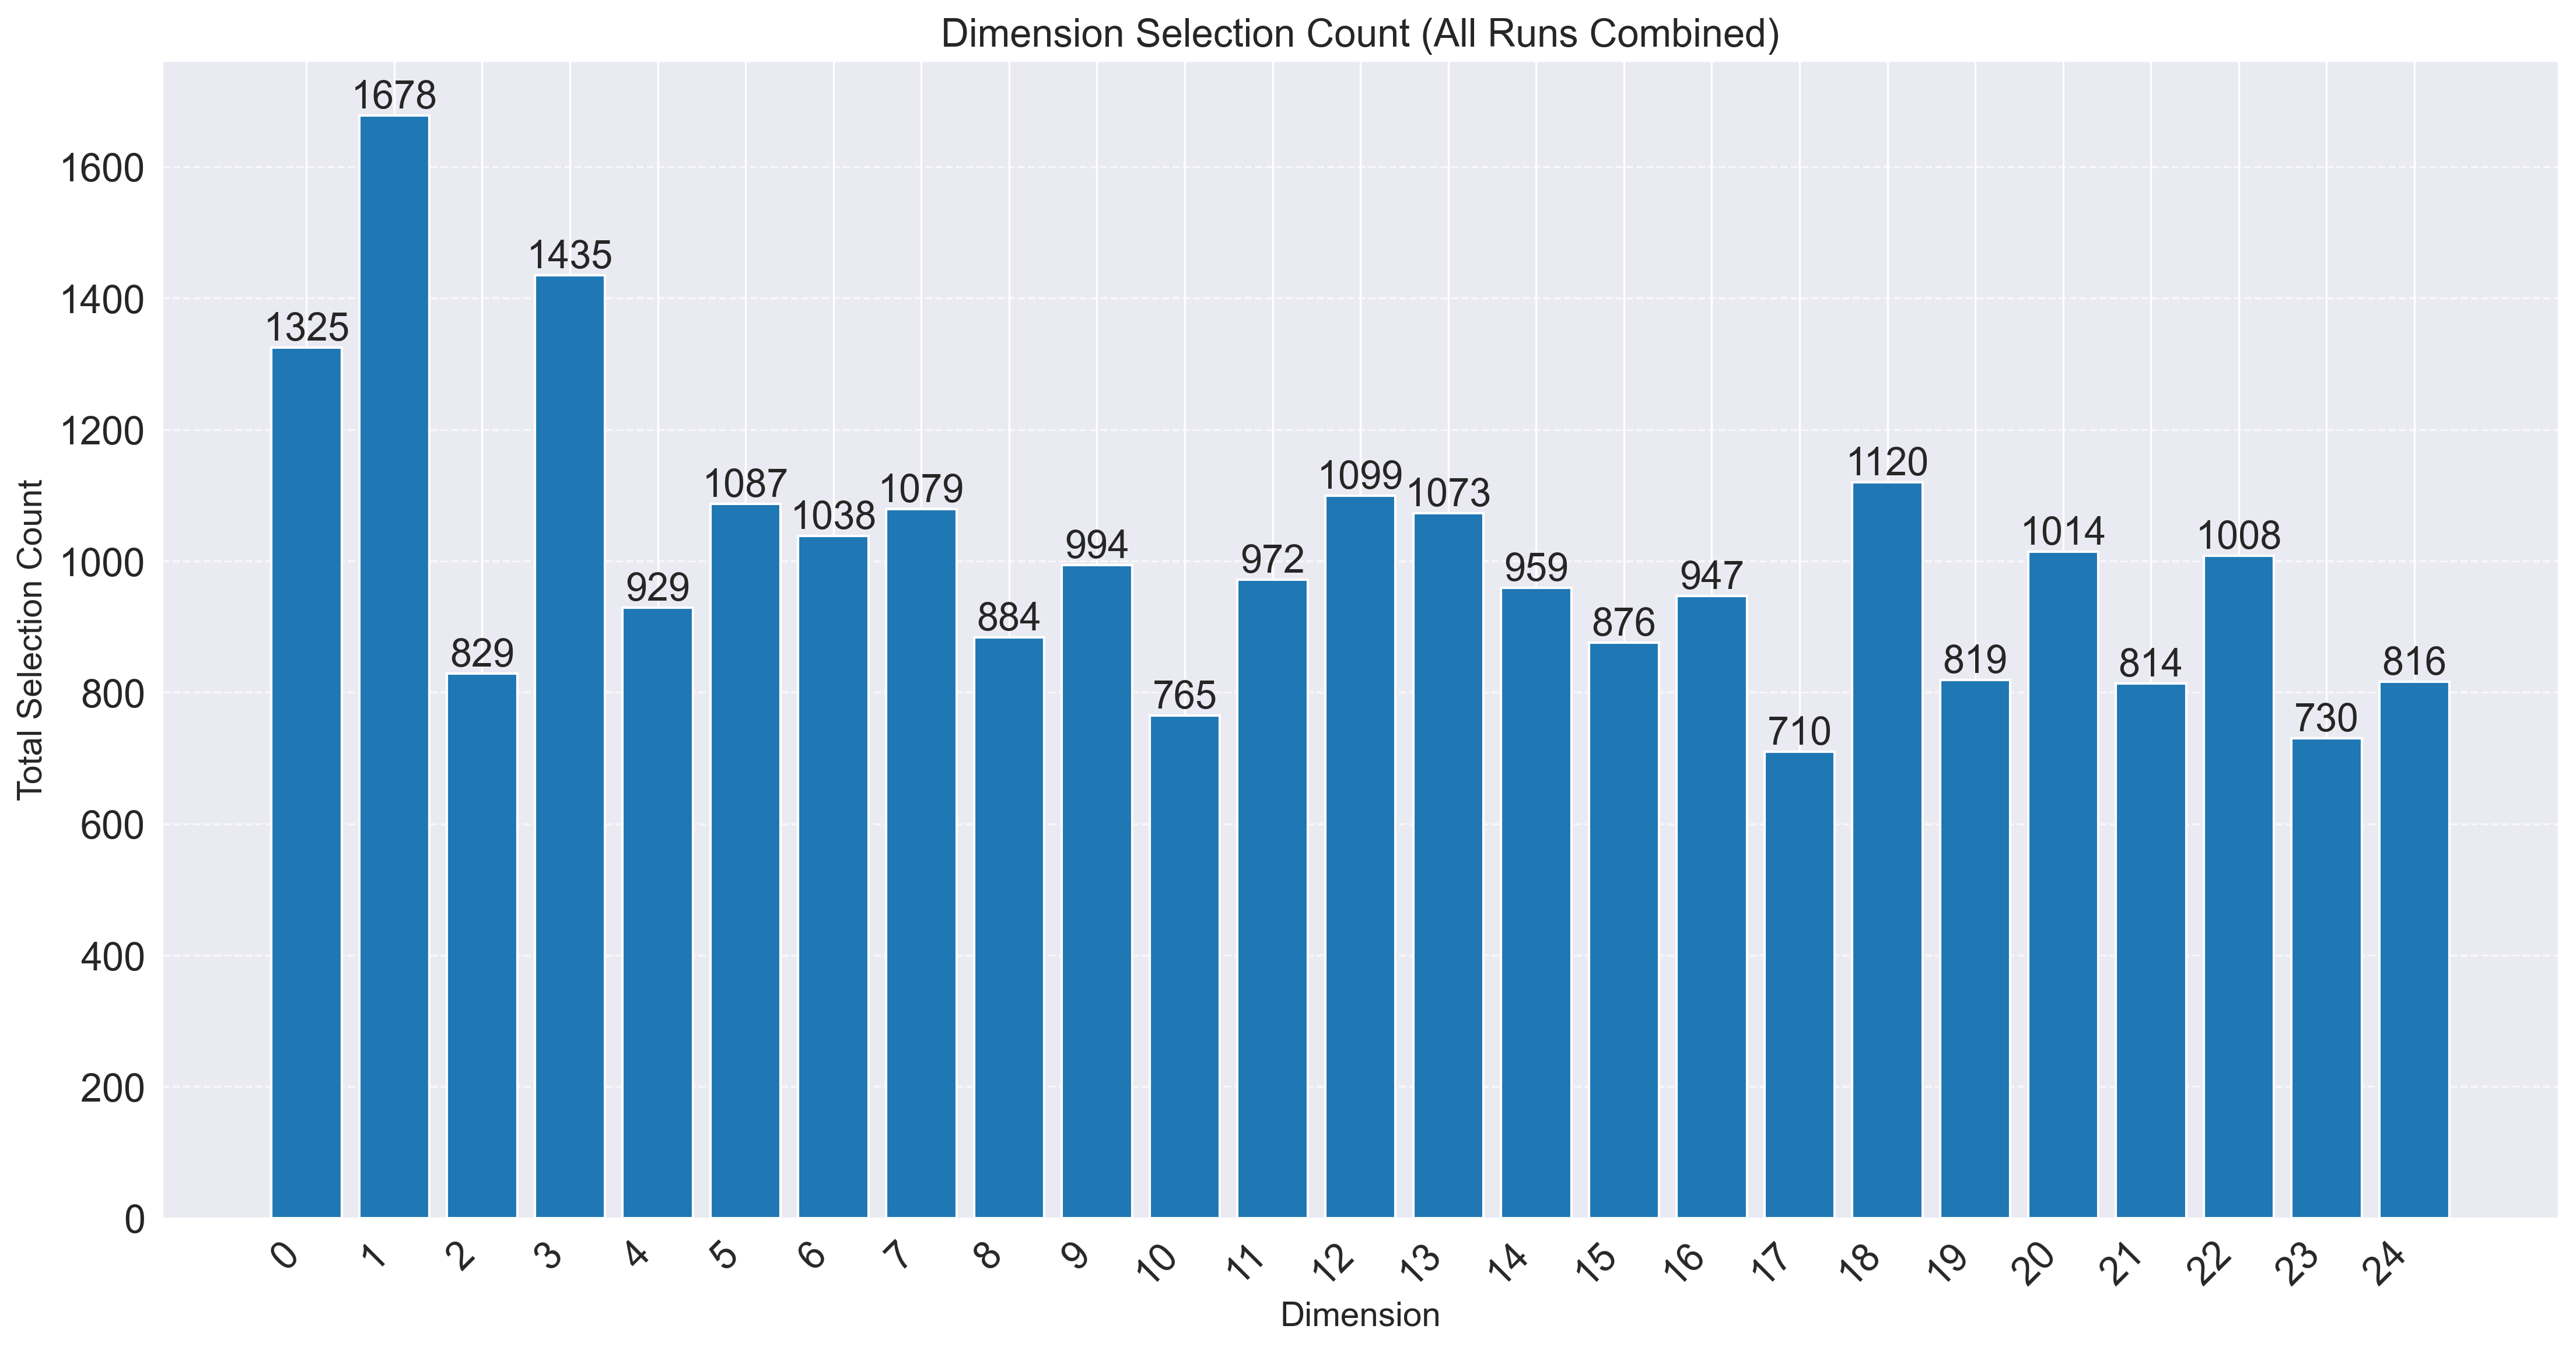

In [179]:
# Flatten and combine all runs
flattened_history = [dim for run in arm_selection_history for sublist in run for dim in sublist]

# Count the occurrences of each dimension
dimension_counts = Counter(flattened_history)

# Create lists for x-axis (dimensions) and y-axis (counts)
dimensions = sorted(dimension_counts.keys())
counts = [dimension_counts[d] for d in dimensions]

# Create the histogram
plt.figure(figsize=(15, 8), dpi=300)
bars = plt.bar(dimensions, counts)
plt.xlabel("Dimension", fontsize=14)
plt.ylabel("Total Selection Count", fontsize=14)
plt.title("Dimension Selection Count (All Runs Combined)", fontsize=16)
plt.xticks(dimensions, rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}',
             ha='center', va='bottom')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()